In [2]:
import pandas as pd
import glob
import os
import json

# Define the folder path
folder_path = "raw_data"  # Change this to your actual folder path

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read each CSV file and store them in a list
df_list = [pd.read_csv(file) for file in csv_files]

# Concatenate all DataFrames into one
df_combined = pd.concat(df_list, ignore_index=True)

# cleaning
df_combined = df_combined.assign(snp = df_combined.snp.str.replace('`', ''))

# add reference alleles
reference = pd.read_csv('reference_genome.csv')

# add onto main df
df_combined = df_combined.merge(reference, how = 'left')

# drop the n = 0 rows
df_combined = df_combined[df_combined.n_total > 0]

# Display the combined DataFrame
df_combined.head()

,phenotype,snp,adjustment,beta,OR,SE,p,type,n_total,n_cases,...,OR.fixed,SE.fixed,p.fixed,beta.random,OR.random,SE.random,p.random,description,group,reference_hg38
0,110.00,16:4353432_T,none,-0.000151,0.999849,0.005953,0.979734,logistic,1237800,177241,...,0.999849,0.005953,0.979734,0.006178,1.006197,0.012305,0.615617,Dermatophytosis / Dermatomycosis,infectious diseases,C
1,110.10,16:4353432_T,none,-0.000312,0.999688,0.006069,0.959032,logistic,1237416,170510,...,0.999688,0.006069,0.959032,0.010304,1.010357,0.015522,0.506800,Dermatophytosis,infectious diseases,C
2,110.11,16:4353432_T,none,0.002182,1.002185,0.006721,0.745428,logistic,1251709,128081,...,1.002185,0.006721,0.745428,0.009433,1.009478,0.016507,0.567693,Dermatophytosis of nail,infectious diseases,C
3,110.12,16:4353432_T,none,0.000275,1.000275,0.010969,0.980001,logistic,1251344,36804,...,1.000275,0.010969,0.980001,0.018498,1.018670,0.022352,0.407917,Althete's foot,infectious diseases,C
4,110.13,16:4353432_T,none,0.027595,1.027980,0.016599,0.096426,logistic,1258137,13211,...,1.027980,0.016599,0.096426,0.027595,1.027980,0.016599,0.096426,Dermatophytosis of the body,infectious diseases,C


In [3]:
# extract the SNP data
df_combined[['chrom', 'pos', 'alternate']] = df_combined.snp.str.extract(r'(\d+):(\d+)_([A-Za-z])')

# rename necessary cols
df_combined = df_combined.assign(

    # clean
    phenocode = df_combined.phenotype,
    phenostring = df_combined.description,
    clean_phenotype = df_combined.description.str.lower().str.replace('[ -]', '_', regex = True).str.replace("[',\\]\\[\\(\\)/;&\\.]", "", regex = True),

    # rename
    reference = df_combined.reference_hg38,
    num_samples = df_combined.n_total,
    num_controls = df_combined.n_controls,
    num_cases = df_combined.n_cases,
    se = df_combined.SE,

    maf = round(df_combined.assign(allele_freq2 = 1 - df_combined.allele_freq)[['allele_freq', 'allele_freq2']].min(axis = 1), 2),
    # maf = df_combined.allele_freq,

    # capitalize the first letter
    category = df_combined.group.str.slice(0,1).str.upper() + df_combined.group.str.slice(1),

    # retype
    chrom = df_combined.chrom.astype(int),
    pos = df_combined.pos.astype(int)
)

df_combined['or'] = df_combined.OR
df_combined['af'] = 1 - df_combined.maf

In [4]:
final_cols = [
    'chrom', 'pos', 'reference', 'alternate', 'p',
    'num_cases', 'num_controls', 'maf', 'af', 'beta', 'se', 'or'
]

In [5]:
df_combined.snp.nunique()

31

In [6]:
df_combined[df_combined.reference == df_combined.alternate][['snp']].drop_duplicates()

,snp
4041,1:198394253_T
10099,2:43078360_T
20015,11:46744925_C
30111,18:77580712_A
48296,13:96488178_A
56376,7:116417848_C
58395,7:27560733_T


In [8]:
df_combined.head().T

,0,1,2,3,4
phenotype,110.0,110.1,110.11,110.12,110.13
snp,16:4353432_T,16:4353432_T,16:4353432_T,16:4353432_T,16:4353432_T
adjustment,none,none,none,none,none
beta,-0.000151,-0.000312,0.002182,0.000275,0.027595
OR,0.999849,0.999688,1.002185,1.000275,1.02798
SE,0.005953,0.006069,0.006721,0.010969,0.016599
p,0.979734,0.959032,0.745428,0.980001,0.096426
type,logistic,logistic,logistic,logistic,logistic
n_total,1237800,1237416,1251709,1251344,1258137
n_cases,177241,170510,128081,36804,13211


In [ ]:
# Where the reference allele equals the alternate allele, 
# swawp the reference and alternate and swap the effect size sign


In [26]:
# drop all snps that where reference == alternate
df_combined = df_combined[df_combined.reference != df_combined.alternate] 

In [27]:
# check that we got all chromosomes
df_combined[df_combined.chrom.isna()][['snp'] + final_cols]

,snp,chrom,pos,reference,alternate,p,num_cases,num_controls,maf,af,beta,se,or


In [40]:
# making the num samples uniform 

num_cases_grouped = df_combined.groupby('phenocode').num_cases.agg(['min', 'max'])
num_controls_grouped = df_combined.groupby('phenocode').num_controls.agg(['min', 'max'])

# Create a new column with either a single number or a range string
def format_range(row):
    if row['min'] == row['max']:
        return str(row['min'])
    else:
        return f"{row['min']} to {row['max']}"

num_cases_grouped['num_cases'] = num_cases_grouped.apply(format_range, axis=1)
num_controls_grouped['num_controls'] = num_controls_grouped.apply(format_range, axis=1)

# If you only want the group and the range:
num_cases_result = num_cases_grouped[['num_cases']].reset_index()
num_controls_result = num_controls_grouped[['num_controls']].reset_index()

num_ranges = num_cases_result.merge(num_controls_result, on = 'phenocode')

In [41]:
num_ranges

,phenocode,num_cases,num_controls
0,110.00,123709 to 177257,963702 to 1075328
1,110.10,119009 to 170523,967382 to 1081675
2,110.11,89250 to 128086,1004353 to 1138397
3,110.12,22946 to 36812,1069540 to 1229309
4,110.13,10295 to 13211,1087838 to 1259695
...,...,...,...
1754,990.00,13156 to 15824,1148894 to 1325757
1755,994.00,30419 to 36860,1137566 to 1307237
1756,994.10,2666 to 2926,1164600 to 1285469
1757,994.20,27716 to 33659,1139763 to 1310256


In [30]:
# sort very important for Pheweb
df_combined = df_combined.sort_values(['phenocode', 'chrom', 'pos'])

In [31]:
# final file
df_combined[['phenocode', 'phenostring', 'clean_phenotype', 'category'] + final_cols].to_csv('all_data.csv', index = False)

<Axes: >

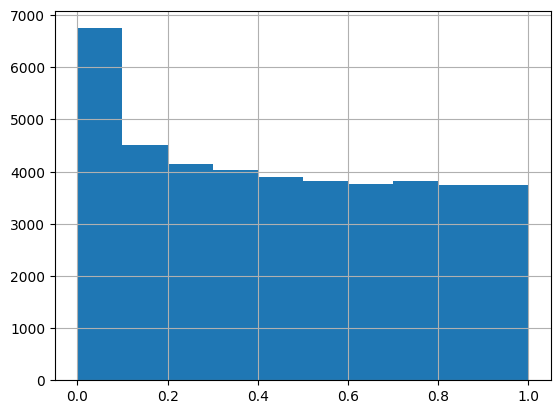

In [32]:
# note that the p-value is raw
df_combined.p.hist()

## Formatting 

I need to format the files a la Github specifications. One file per phenotype

In [33]:
# filtering out phenotypes with n = 0
# this isn't a problem with the phenotypes, this is because we filtered out some genes because the reference alleles didn't match
n_totals = df_combined.groupby('phenocode').n_total.sum()
phenotypes_n_0 = pd.Series(n_totals[n_totals == 0].index)
df_combined = df_combined[~ df_combined.phenocode.isin(phenotypes_n_0)]

In [34]:
unique_phenotypes = df_combined[['phenocode', 'phenostring', 'category', 'clean_phenotype']].drop_duplicates()

# check for consistent phenotype categories
if unique_phenotypes.shape[0] != df_combined.phenocode.nunique():
    raise ValueError("Non-unique phenotype categories. One or more phenotypes have multiple categories")

In [35]:
df_combined.columns

Index(['phenotype', 'snp', 'adjustment', 'beta', 'OR', 'SE', 'p', 'type',
       'n_total', 'n_cases', 'n_controls', 'HWE_p.min', 'allele_freq',
       'n_no_snp', 'k_studies', 'tau2', 'I2.percent', 'Q', 'Q.df', 'Q.p',
       'beta.fixed', 'OR.fixed', 'SE.fixed', 'p.fixed', 'beta.random',
       'OR.random', 'SE.random', 'p.random', 'description', 'group',
       'reference_hg38', 'chrom', 'pos', 'alternate', 'phenocode',
       'phenostring', 'clean_phenotype', 'reference', 'num_samples',
       'num_controls', 'num_cases', 'se', 'maf', 'category', 'or', 'af'],
      dtype='object')

In [36]:
# df_combined[['phenocode', 'phenostring', 'category', 'n_total', 'snp']].drop_duplicates().head(20)

In [60]:
# remove all files in folder
import os
import glob

files = glob.glob('clean_data/*.csv')
for f in files:
    os.remove(f)

# make a file for each phenotype
for pheno in unique_phenotypes.clean_phenotype:
    df_combined[df_combined.clean_phenotype == pheno][final_cols].to_csv('clean_data/' + str(pheno) + '.csv', index = False)

In [37]:
pheno_df = unique_phenotypes.assign(
    assoc_files = 'clean_data/' + unique_phenotypes.clean_phenotype + '.csv'
    )[['assoc_files',  'category', 'phenocode', 'phenostring']]

pheno_df.to_csv('pheno-list.csv', index = False)

In [42]:
# merge on numeric ranges
pheno_df = pheno_df.merge(num_ranges, on = 'phenocode', how = 'left')

In [43]:
pheno_df

,assoc_files,category,phenocode,phenostring,cases_range,controls_range,num_cases,num_controls
0,clean_data/dermatophytosis__dermatomycosis.csv,Infectious diseases,110.00,Dermatophytosis / Dermatomycosis,123709 to 177257,963702 to 1075328,123709 to 177257,963702 to 1075328
1,clean_data/dermatophytosis.csv,Infectious diseases,110.10,Dermatophytosis,119009 to 170523,967382 to 1081675,119009 to 170523,967382 to 1081675
2,clean_data/dermatophytosis_of_nail.csv,Infectious diseases,110.11,Dermatophytosis of nail,89250 to 128086,1004353 to 1138397,89250 to 128086,1004353 to 1138397
3,clean_data/althetes_foot.csv,Infectious diseases,110.12,Althete's foot,22946 to 36812,1069540 to 1229309,22946 to 36812,1069540 to 1229309
4,clean_data/dermatophytosis_of_the_body.csv,Infectious diseases,110.13,Dermatophytosis of the body,10295 to 13211,1087838 to 1259695,10295 to 13211,1087838 to 1259695
...,...,...,...,...,...,...,...,...
1754,clean_data/effects_radiation_nos.csv,Injuries & poisonings,990.00,Effects radiation NOS,13156 to 15824,1148894 to 1325757,13156 to 15824,1148894 to 1325757
1755,clean_data/sepsis_and_sirs.csv,Injuries & poisonings,994.00,Sepsis and SIRS,30419 to 36860,1137566 to 1307237,30419 to 36860,1137566 to 1307237
1756,clean_data/systemic_inflammatory_response_synd...,Injuries & poisonings,994.10,Systemic inflammatory response syndrome (SIRS),2666 to 2926,1164600 to 1285469,2666 to 2926,1164600 to 1285469
1757,clean_data/sepsis.csv,Injuries & poisonings,994.20,Sepsis,27716 to 33659,1139763 to 1310256,27716 to 33659,1139763 to 1310256


In [44]:

json_df = pheno_df.assign(phenocode = pheno_df.phenocode.astype(str))

# Ensure 'assoc_files' becomes a list of one file per row
json_df["assoc_files"] = json_df["assoc_files"].apply(lambda x: [x])

# Convert to list of dicts
pheno_json = json_df.to_dict(orient="records")

# Write to JSON file
with open("pheno-list.json", "w") as f:
    json.dump(pheno_json, f, indent=2)